# Example execution of MESMER-M workflow for multiple scenarios and ensemble members
Training and emulation of monthly local temperature from yearly local temperature. We use an example data set on a coarse (20° x 20°) grid.

Import libraries and check MESMER version:

In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import importlib

import filefinder
import pandas
import xarray as xr
from datatree import DataTree, map_over_subtree
from filefinder import FileContainer

import mesmer

mesmer.__version__

'0.10.0.post1.dev143+gfc10078.d20241008'

## Calibrate emulator

### Configuration

In [25]:
LOCALISATION_RADII = list(range(1250, 6251, 250)) + list(range(6500, 8501, 500))
THRESHOLD_LAND = 1 / 3
REF_PERIOD = slice("1850", "1900")

In [26]:
# define paths of the example data

model = "IPSL-CM6A-LR"
scenarios = ["ssp585", "ssp126"]

TEST_DATA_PATH = importlib.resources.files("mesmer").parent / "tests" / "test-data"
cmip6_data_path = TEST_DATA_PATH / "calibrate-coarse-grid" / "cmip6-ng"

path_tas_mon = cmip6_data_path / "tas" / "mon" / "g025"
fN_hist_mon = path_tas_mon / f"tas_mon_{model}_historical_r1i1p1f1_g025.nc"
fN_proj_mon = path_tas_mon / f"tas_mon_{model}_ssp585_r1i1p1f1_g025.nc"

### Load Data for training the emulator

In [27]:
CMIP_FILEFINDER = filefinder.FileFinder(
    path_pattern=cmip6_data_path / "{variable}/{time_res}/{resolution}",
    file_pattern="{variable}_{time_res}_{model}_{scenario}_{member}_{resolution}.nc",
)

In [28]:
fc_scens_y = CMIP_FILEFINDER.find_files(
    variable="tas", scenario=scenarios, model=model, resolution="g025", time_res="ann"
)

# only get the historical members that are also in the future scenarios, but only once
unique_scen_members_y = fc_scens_y.df.member.unique()

fc_hist_y = CMIP_FILEFINDER.find_files(
    variable="tas",
    scenario="historical",
    model=model,
    resolution="g025",
    time_res="ann",
    member=unique_scen_members_y,
)

fc_all_y = FileContainer(pandas.concat([fc_hist_y.df, fc_scens_y.df]))
fc_all_y.df

,filename,variable,time_res,resolution,model,scenario,member
0,/Users/vbauer/Developer/mesmer/tests/test-data...,tas,ann,g025,IPSL-CM6A-LR,historical,r1i1p1f1
1,/Users/vbauer/Developer/mesmer/tests/test-data...,tas,ann,g025,IPSL-CM6A-LR,historical,r2i1p1f1
0,/Users/vbauer/Developer/mesmer/tests/test-data...,tas,ann,g025,IPSL-CM6A-LR,ssp585,r1i1p1f1
1,/Users/vbauer/Developer/mesmer/tests/test-data...,tas,ann,g025,IPSL-CM6A-LR,ssp585,r2i1p1f1
2,/Users/vbauer/Developer/mesmer/tests/test-data...,tas,ann,g025,IPSL-CM6A-LR,ssp126,r1i1p1f1


In [29]:
fc_scens_m = CMIP_FILEFINDER.find_files(
    variable="tas", scenario=scenarios, model=model, resolution="g025", time_res="mon"
)

# only get the historical members that are also in the future scenarios, but only once
unique_scen_members_m = fc_scens_y.df.member.unique()

fc_hist_m = CMIP_FILEFINDER.find_files(
    variable="tas",
    scenario="historical",
    model=model,
    resolution="g025",
    time_res="mon",
    member=unique_scen_members_m,
)

fc_all_m = FileContainer(pandas.concat([fc_hist_m.df, fc_scens_m.df]))
fc_all_m.df

,filename,variable,time_res,resolution,model,scenario,member
0,/Users/vbauer/Developer/mesmer/tests/test-data...,tas,mon,g025,IPSL-CM6A-LR,historical,r1i1p1f1
1,/Users/vbauer/Developer/mesmer/tests/test-data...,tas,mon,g025,IPSL-CM6A-LR,historical,r2i1p1f1
0,/Users/vbauer/Developer/mesmer/tests/test-data...,tas,mon,g025,IPSL-CM6A-LR,ssp585,r1i1p1f1
1,/Users/vbauer/Developer/mesmer/tests/test-data...,tas,mon,g025,IPSL-CM6A-LR,ssp585,r2i1p1f1
2,/Users/vbauer/Developer/mesmer/tests/test-data...,tas,mon,g025,IPSL-CM6A-LR,ssp126,r1i1p1f1


In [30]:
tas_y = DataTree()

scenarios_whist = scenarios.copy()
scenarios_whist.append("historical")

# load data for each scenario
for scen in scenarios_whist:
    files = fc_all_y.search(scenario=scen)

    # load all members for a scenario
    members = []
    for fN, meta in files:
        ds = xr.open_dataset(fN, use_cftime=True)
        # drop unnecessary variables
        ds = ds.drop_vars(["height", "time_bnds", "file_qf"], errors="ignore")
        # assign member-ID as coordinate
        ds = ds.assign_coords({"member": meta["member"]})
        members.append(ds)

    # create a Dataset that holds each member along the member dimension
    scen_data = xr.concat(members, dim="member")
    # put the scenario dataset into the DataTree
    tas_y[f"{scen}"] = DataTree(scen_data)

tas_y

DataTree('None', parent=None)
├── DataTree('ssp585')
│       Dimensions:  (time: 86, lon: 20, lat: 20, member: 2)
│       Coordinates:
│         * time     (time) object 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
│         * lon      (lon) float64 0.0 18.0 36.0 54.0 72.0 ... 288.0 306.0 324.0 342.0
│         * lat      (lat) float64 -85.5 -76.5 -67.5 -58.5 -49.5 ... 58.5 67.5 76.5 85.5
│         * member   (member) <U8 'r1i1p1f1' 'r2i1p1f1'
│       Data variables:
│           tas      (member, time, lat, lon) float64 226.4 225.0 223.4 ... 275.5 277.2
│       Attributes: (12/56)
│           CDI:                       Climate Data Interface version 2.1.0 (https://...
│           source:                    IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; ...
│           institution:               Institut Pierre Simon Laplace, Paris 75252, Fr...
│           Conventions:               CF-1.7 CMIP-6.2
│           history:                   Wed Oct 26 15:35:08 2022: cdo remapbil,r20x20 ...
│           name:                      /ccc/work/cont003/gencmip6/oboucher/IGCM_OUT/I...
│           ...                        ...
│           dr2xml_md5sum:             c2dce418e78ca835be1e2ff817c2c403
│           model_version:             6.1.8
│           cmip6-ng:                  \ncontact = cmip6-archive@env.ethz.ch\ndescrip...
│           original_file_names:       /net/atmos/data/cmip6/ssp585/Amon/tas/IPSL-CM6...
│           original_file_hash_codes:  a2117793ca25ad66f75a37be51fd2e6165c2ba2684b7d4...
│           CDO:                       Climate Data Operators version 2.1.0 (https://...
├── DataTree('ssp126')
│       Dimensions:  (time: 86, lon: 20, lat: 20, member: 1)
│       Coordinates:
│         * time     (time) object 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
│         * lon      (lon) float64 0.0 18.0 36.0 54.0 72.0 ... 288.0 306.0 324.0 342.0
│         * lat      (lat) float64 -85.5 -76.5 -67.5 -58.5 -49.5 ... 58.5 67.5 76.5 85.5
│         * member   (member) <U8 'r1i1p1f1'
│       Data variables:
│           tas      (member, time, lat, lon) float64 227.7 226.1 224.3 ... 263.4 264.9
│       Attributes: (12/56)
│           CDI:                       Climate Data Interface version 1.9.9 (https://...
│           source:                    IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; ...
│           institution:               Institut Pierre Simon Laplace, Paris 75252, Fr...
│           Conventions:               CF-1.7 CMIP-6.2
│           history:                   Thu Mar 18 19:05:09 2021: cdo remapbil,r20x20 ...
│           name:                      /ccc/work/cont003/gencmip6/oboucher/IGCM_OUT/I...
│           ...                        ...
│           dr2xml_md5sum:             c2dce418e78ca835be1e2ff817c2c403
│           model_version:             6.1.8
│           cmip6-ng:                  \ncontact = cmip6-archive@env.ethz.ch\ndescrip...
│           original_file_names:       /net/atmos/data/cmip6/ssp126/Amon/tas/IPSL-CM6...
│           original_file_hash_codes:  8cfb5fd339c050bc81d2e2eeb7263ceec89c295d15631b...
│           CDO:                       Climate Data Operators version 1.9.9 (https://...
└── DataTree('historical')
        Dimensions:  (time: 165, lon: 20, lat: 20, member: 2)
        Coordinates:
          * time     (time) object 1850-07-01 06:00:00 ... 2014-07-01 06:00:00
          * lon      (lon) float64 0.0 18.0 36.0 54.0 72.0 ... 288.0 306.0 324.0 342.0
          * lat      (lat) float64 -85.5 -76.5 -67.5 -58.5 -49.5 ... 58.5 67.5 76.5 85.5
          * member   (member) <U8 'r1i1p1f1' 'r2i1p1f1'
        Data variables:
            tas      (member, time, lat, lon) float64 226.3 225.0 223.5 ... 258.4 259.6
        Attributes: (12/56)
            CDI:                       Climate Data Interface version 1.9.9 (https://...
            source:                    IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; ...
            institution:               Institut Pierre Simon Laplace, Paris 75252, Fr...
         

In [31]:
tas_m = DataTree()

scenarios_whist = scenarios.copy()
scenarios_whist.append("historical")

# load data for each scenario
for scen in scenarios_whist:
    files = fc_all_m.search(scenario=scen)

    # load all members for a scenario
    members = []
    for fN, meta in files:
        ds = xr.open_dataset(fN, use_cftime=True)
        # drop unnecessary variables
        ds = ds.drop_vars(["height", "time_bnds", "file_qf"], errors="ignore")
        # assign member-ID as coordinate
        ds = ds.assign_coords({"member": meta["member"]})
        members.append(ds)

    # create a Dataset that holds each member along the member dimension
    scen_data = xr.concat(members, dim="member")
    # put the scenario dataset into the DataTree
    tas_m[f"{scen}"] = DataTree(scen_data)

tas_m

DataTree('None', parent=None)
├── DataTree('ssp585')
│       Dimensions:  (time: 1032, lon: 20, lat: 20, member: 2)
│       Coordinates:
│         * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│         * lon      (lon) float64 0.0 18.0 36.0 54.0 72.0 ... 288.0 306.0 324.0 342.0
│         * lat      (lat) float64 -85.5 -76.5 -67.5 -58.5 -49.5 ... 58.5 67.5 76.5 85.5
│         * member   (member) <U8 'r1i1p1f1' 'r2i1p1f1'
│       Data variables:
│           tas      (member, time, lat, lon) float64 247.0 246.1 244.6 ... 272.9 274.8
│       Attributes: (12/56)
│           CDI:                       Climate Data Interface version 2.3.0 (https://...
│           Conventions:               CF-1.7 CMIP-6.2
│           source:                    IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; ...
│           institution:               Institut Pierre Simon Laplace, Paris 75252, Fr...
│           history:                   Wed Mar 13 18:07:13 2024: cdo remapbil,r20x20 ...
│           name:                      /ccc/work/cont003/gencmip6/oboucher/IGCM_OUT/I...
│           ...                        ...
│           dr2xml_md5sum:             c2dce418e78ca835be1e2ff817c2c403
│           model_version:             6.1.8
│           cmip6-ng:                  \ncontact = cmip6-archive@env.ethz.ch\ndescrip...
│           original_file_names:       /net/atmos/data/cmip6/ssp585/Amon/tas/IPSL-CM6...
│           original_file_hash_codes:  a2117793ca25ad66f75a37be51fd2e6165c2ba2684b7d4...
│           CDO:                       Climate Data Operators version 2.3.0 (https://...
├── DataTree('ssp126')
│       Dimensions:  (time: 1032, lon: 20, lat: 20, member: 1)
│       Coordinates:
│         * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│         * lon      (lon) float64 0.0 18.0 36.0 54.0 72.0 ... 288.0 306.0 324.0 342.0
│         * lat      (lat) float64 -85.5 -76.5 -67.5 -58.5 -49.5 ... 58.5 67.5 76.5 85.5
│         * member   (member) <U8 'r1i1p1f1'
│       Data variables:
│           tas      (member, time, lat, lon) float64 247.0 245.7 244.0 ... 255.5 258.4
│       Attributes: (12/56)
│           CDI:                       Climate Data Interface version 1.9.6 (http://m...
│           history:                   Tue Dec 03 09:39:48 2024: cdo remapbil,r20x20 ...
│           source:                    IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; ...
│           institution:               Institut Pierre Simon Laplace, Paris 75252, Fr...
│           Conventions:               CF-1.7 CMIP-6.2
│           name:                      /ccc/work/cont003/gencmip6/oboucher/IGCM_OUT/I...
│           ...                        ...
│           dr2xml_md5sum:             c2dce418e78ca835be1e2ff817c2c403
│           model_version:             6.1.8
│           cmip6-ng:                  \ncontact = cmip6-archive@env.ethz.ch\ndescrip...
│           original_file_names:       /net/atmos/data/cmip6/ssp126/Amon/tas/IPSL-CM6...
│           original_file_hash_codes:  8cfb5fd339c050bc81d2e2eeb7263ceec89c295d15631b...
│           CDO:                       Climate Data Operators version 1.9.6 (http://m...
└── DataTree('historical')
        Dimensions:  (time: 1980, lon: 20, lat: 20, member: 2)
        Coordinates:
          * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
          * lon      (lon) float64 0.0 18.0 36.0 54.0 72.0 ... 288.0 306.0 324.0 342.0
          * lat      (lat) float64 -85.5 -76.5 -67.5 -58.5 -49.5 ... 58.5 67.5 76.5 85.5
          * member   (member) <U8 'r1i1p1f1' 'r2i1p1f1'
        Data variables:
            tas      (member, time, lat, lon) float64 247.4 246.5 245.3 ... 251.8 253.5
        Attributes: (12/56)
            CDI:                       Climate Data Interface version 2.3.0 (https://...
            Conventions:               CF-1.7 CMIP-6.2
            source:                    IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; ...
            institution:              

### Preprocessing

Calculate anomalies w.r.t the reference period

In [32]:
ref_y = tas_y["historical"].sel(time=REF_PERIOD).mean("time", keep_attrs=True)
ref_m = tas_m["historical"].sel(time=REF_PERIOD).mean("time", keep_attrs=True)

tas_y = tas_y - ref_y.ds
tas_m = tas_m - ref_m.ds

We only use land grid points and exclude Antarctica. The 3D data with dimensions `('time', 'lat', 'lon')` is stacked to 2D data with dimensions `('time', 'gridcell')`:

In [33]:
def mask_and_stack(ds, threshold_land):
    ds = mesmer.mask.mask_ocean_fraction(ds, threshold_land)
    ds = mesmer.mask.mask_antarctica(ds)
    ds = mesmer.grid.stack_lat_lon(ds)
    # ds = ds.stack(sample = ("member", "time"))
    return ds

In [34]:
tas_stacked_y = map_over_subtree(mask_and_stack)(tas_y, threshold_land=THRESHOLD_LAND)
tas_stacked_m = map_over_subtree(mask_and_stack)(tas_m, threshold_land=THRESHOLD_LAND)

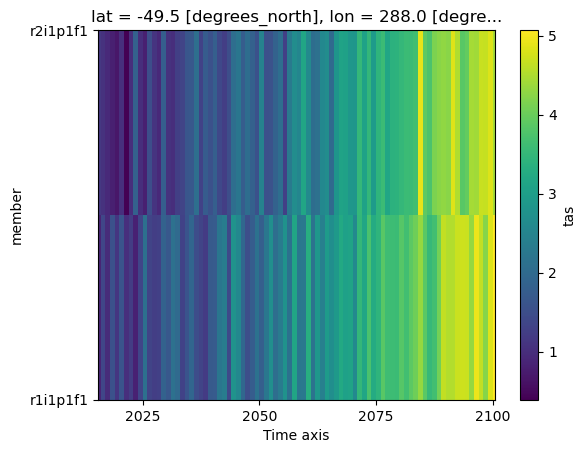

In [35]:
tas_stacked_y["ssp585"].tas.isel(gridcell=0).plot(x="time")

### Fit the harmonic model

Fit the seasonal cycle with a harmonic model which can vary with local annual mean temperature
(fourier regression). Removes annual mean and, determines the optimal order and the coefficients
of the harmonic model

In [ ]:
def extract_da_and_call_func(func, ds_y, ds_m, **kwargs):
    yearly_dat = ds_y.tas
    monthly_dat = ds_m.tas
    return func(yearly_dat, monthly_dat, **kwargs)

In [81]:
harmonic_model_fit = map_over_subtree(extract_da_and_call_func)(
    mesmer.stats.fit_harmonic_model, tas_stacked_y, tas_stacked_m
)
harmonic_model_fit

DataTree('None', parent=None)
├── DataTree('ssp585')
│       Dimensions:         (member: 2, gridcell: 118, coeff: 24, time: 1032)
│       Coordinates:
│         * member          (member) <U8 'r1i1p1f1' 'r2i1p1f1'
│           lat             (gridcell) float64 -49.5 -40.5 -31.5 ... 76.5 76.5 76.5
│           lon             (gridcell) float64 288.0 288.0 18.0 ... 306.0 324.0 342.0
│         * coeff           (coeff) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
│         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│       Dimensions without coordinates: gridcell
│       Data variables:
│           selected_order  (member, gridcell) int64 1 2 2 2 2 2 3 2 ... 2 3 4 3 3 2 2 4
│           coeffs          (member, gridcell, coeff) float64 -0.06249 4.757 ... nan nan
│           predictions     (time, member, gridcell) float64 5.567 7.099 ... 1.854 12.54
├── DataTree('ssp126')
│       Dimensions:         (member: 1, gridcell: 118, coeff: 24, time: 1032)
│       Coordinates:
│         * member          (member) <U8 'r1i1p1f1'
│           lat             (gridcell) float64 -49.5 -40.5 -31.5 ... 76.5 76.5 76.5
│           lon             (gridcell) float64 288.0 288.0 18.0 ... 306.0 324.0 342.0
│         * coeff           (coeff) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
│         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│       Dimensions without coordinates: gridcell
│       Data variables:
│           selected_order  (member, gridcell) int64 2 2 2 2 2 2 3 2 ... 2 3 3 3 4 2 2 3
│           coeffs          (member, gridcell, coeff) float64 -0.05303 4.619 ... nan nan
│           predictions     (time, member, gridcell) float64 4.963 6.318 ... -0.6448
└── DataTree('historical')
        Dimensions:         (member: 2, gridcell: 118, coeff: 24, time: 1980)
        Coordinates:
          * member          (member) <U8 'r1i1p1f1' 'r2i1p1f1'
            lat             (gridcell) float64 -49.5 -40.5 -31.5 ... 76.5 76.5 76.5
            lon             (gridcell) float64 288.0 288.0 18.0 ... 306.0 324.0 342.0
          * coeff           (coeff) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
          * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
        Dimensions without coordinates: gridcell
        Data variables:
            selected_order  (member, gridcell) int64 2 2 2 2 2 2 2 2 ... 2 3 3 3 3 2 2 4
            coeffs          (member, gridcell, coeff) float64 -0.1902 4.7 ... nan nan
            predictions     (time, member, gridcell) float64 4.322 5.251 ... -5.66

In [98]:
def _avg_for_dtype(ds, dim):
    def avg_da(da, dim):
        if da.dtype == int:
            return da.quantile(q=0.5, dim=dim, method="nearest", skipna=True)
        else:
            return da.mean(dim=dim, skipna=True)

    return ds.map(avg_da, dim=dim)


def _avg_ens_then_scen(dt, ens_dim="member"):
    ens_mean = map_over_subtree(_avg_for_dtype)(dt, dim=ens_dim)
    ds_ens_mean = mesmer.datatree.collapse_datatree_into_dataset(
        ens_mean, dim="scenario"
    )
    scen_mean = _avg_for_dtype(ds_ens_mean, dim="scenario")
    return scen_mean

In [99]:
# average over ensemble members and scenarios
# do not average predictions, drop time dim (is only present on predicitions) to avoid nans
harmonic_model_fit_wo_preds = harmonic_model_fit.drop_vars(("predictions", "time"))
harmonic_model_fit_scen_mean = _avg_ens_then_scen(
    harmonic_model_fit_wo_preds
).drop_vars("quantile")
harmonic_model_fit_scen_mean

<xarray.Dataset>
Dimensions:         (gridcell: 118, coeff: 24)
Coordinates:
    lat             (gridcell) float64 -49.5 -40.5 -31.5 ... 76.5 76.5 76.5
    lon             (gridcell) float64 288.0 288.0 18.0 ... 306.0 324.0 342.0
  * coeff           (coeff) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
Dimensions without coordinates: gridcell
Data variables:
    selected_order  (gridcell) int64 2 2 2 2 2 2 3 2 2 2 ... 2 2 2 3 3 3 3 2 2 3
    coeffs          (gridcell, coeff) float64 -0.1281 4.687 0.02441 ... nan nan

### Train the power transformer

The residuals are not necessarily symmetric - make them more normal using a Yeo-Johnson
transformation. The parameter $\lambda$ is modelled with a logistic regression using
local annual mean temperature as covariate.

In [100]:
# harmonic_model_predictions = harmonic_model
resids_after_hm = map_over_subtree(lambda m_dat, hm_dat: m_dat - hm_dat.predictions)(
    tas_stacked_m, harmonic_model_fit
)
resids_after_hm

DataTree('None', parent=None)
├── DataTree('ssp585')
│       Dimensions:  (time: 1032, member: 2, gridcell: 118)
│       Coordinates:
│         * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│         * member   (member) <U8 'r1i1p1f1' 'r2i1p1f1'
│           lat      (gridcell) float64 -49.5 -40.5 -31.5 -31.5 ... 76.5 76.5 76.5 76.5
│           lon      (gridcell) float64 288.0 288.0 18.0 126.0 ... 306.0 324.0 342.0
│       Dimensions without coordinates: gridcell
│       Data variables:
│           tas      (member, time, gridcell) float64 -1.567 -1.421 ... 2.328 -1.089
├── DataTree('ssp126')
│       Dimensions:  (time: 1032, member: 1, gridcell: 118)
│       Coordinates:
│         * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│         * member   (member) <U8 'r1i1p1f1'
│           lat      (gridcell) float64 -49.5 -40.5 -31.5 -31.5 ... 76.5 76.5 76.5 76.5
│           lon      (gridcell) float64 288.0 288.0 18.0 126.0 ... 306.0 324.0 342.0
│       Dimensions without coordinates: gridcell
│       Data variables:
│           tas      (member, time, gridcell) float64 -0.1694 0.4014 ... -1.458 -3.588
└── DataTree('historical')
        Dimensions:  (time: 1980, member: 2, gridcell: 118)
        Coordinates:
          * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
          * member   (member) <U8 'r1i1p1f1' 'r2i1p1f1'
            lat      (gridcell) float64 -49.5 -40.5 -31.5 -31.5 ... 76.5 76.5 76.5 76.5
            lon      (gridcell) float64 288.0 288.0 18.0 126.0 ... 306.0 324.0 342.0
        Dimensions without coordinates: gridcell
        Data variables:
            tas      (member, time, gridcell) float64 -0.8485 -1.419 ... 1.416 -0.1426

In [101]:
pt_coefficients = map_over_subtree(extract_da_and_call_func)(
    mesmer.stats.fit_yeo_johnson_transform, tas_stacked_y, resids_after_hm
)
pt_coefficients

DataTree('None', parent=None)
├── DataTree('ssp585')
│       Dimensions:        (member: 2, gridcell: 118, coeff: 2, month: 12)
│       Coordinates:
│         * member         (member) <U8 'r1i1p1f1' 'r2i1p1f1'
│           lat            (gridcell) float64 -49.5 -40.5 -31.5 -31.5 ... 76.5 76.5 76.5
│           lon            (gridcell) float64 288.0 288.0 18.0 ... 306.0 324.0 342.0
│         * coeff          (coeff) int64 0 1
│         * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
│       Dimensions without coordinates: gridcell
│       Data variables:
│           lambda_coeffs  (month, member, gridcell, coeff) float64 0.8109 ... -0.04237
├── DataTree('ssp126')
│       Dimensions:        (member: 1, gridcell: 118, coeff: 2, month: 12)
│       Coordinates:
│         * member         (member) <U8 'r1i1p1f1'
│           lat            (gridcell) float64 -49.5 -40.5 -31.5 -31.5 ... 76.5 76.5 76.5
│           lon            (gridcell) float64 288.0 288.0 18.0 ... 306.0 324.0 342.0
│         * coeff          (coeff) int64 0 1
│         * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
│       Dimensions without coordinates: gridcell
│       Data variables:
│           lambda_coeffs  (month, member, gridcell, coeff) float64 0.9336 0.1 ... -0.1
└── DataTree('historical')
        Dimensions:        (member: 2, gridcell: 118, coeff: 2, month: 12)
        Coordinates:
          * member         (member) <U8 'r1i1p1f1' 'r2i1p1f1'
            lat            (gridcell) float64 -49.5 -40.5 -31.5 -31.5 ... 76.5 76.5 76.5
            lon            (gridcell) float64 288.0 288.0 18.0 ... 306.0 324.0 342.0
          * coeff          (coeff) int64 0 1
          * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
        Dimensions without coordinates: gridcell
        Data variables:
            lambda_coeffs  (month, member, gridcell, coeff) float64 1.369 ... -0.007079

In [102]:
pt_coefficients_scen_mean = _avg_ens_then_scen(pt_coefficients)
pt_coefficients_scen_mean

<xarray.Dataset>
Dimensions:        (gridcell: 118, coeff: 2, month: 12)
Coordinates:
    lat            (gridcell) float64 -49.5 -40.5 -31.5 -31.5 ... 76.5 76.5 76.5
    lon            (gridcell) float64 288.0 288.0 18.0 ... 306.0 324.0 342.0
  * coeff          (coeff) int64 0 1
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: gridcell
Data variables:
    lambda_coeffs  (month, gridcell, coeff) float64 1.09 0.07492 ... -0.04326

In [104]:
def extract_das_and_call_yeo_johnson_transform(ds_y, ds_m, lambda_coeffs_ds):
    yearly_dat = ds_y.tas
    monthly_dat = ds_m.tas
    lambda_coeffs = lambda_coeffs_ds.lambda_coeffs
    return mesmer.stats.yeo_johnson_transform(yearly_dat, monthly_dat, lambda_coeffs)

In [105]:
transformed_hm_resids = map_over_subtree(extract_das_and_call_yeo_johnson_transform)(
    tas_stacked_y,
    resids_after_hm,
    pt_coefficients,
)
transformed_hm_resids

DataTree('None', parent=None)
├── DataTree('ssp585')
│       Dimensions:      (time: 1032, member: 2, gridcell: 118, month: 12, year: 86)
│       Coordinates:
│         * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│         * member       (member) <U8 'r1i1p1f1' 'r2i1p1f1'
│           lat          (gridcell) float64 -49.5 -40.5 -31.5 -31.5 ... 76.5 76.5 76.5
│           lon          (gridcell) float64 288.0 288.0 18.0 126.0 ... 306.0 324.0 342.0
│         * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
│         * year         (year) object 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
│       Dimensions without coordinates: gridcell
│       Data variables:
│           transformed  (member, gridcell, time) float64 -1.516 0.3648 ... -1.057
│           lambdas      (month, member, gridcell, year) float64 1.061 1.036 ... 1.071
├── DataTree('ssp126')
│       Dimensions:      (time: 1032, member: 1, gridcell: 118, month: 12, year: 86)
│       Coordinates:
│         * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│         * member       (member) <U8 'r1i1p1f1'
│           lat          (gridcell) float64 -49.5 -40.5 -31.5 -31.5 ... 76.5 76.5 76.5
│           lon          (gridcell) float64 288.0 288.0 18.0 126.0 ... 306.0 324.0 342.0
│         * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
│         * year         (year) object 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
│       Dimensions without coordinates: gridcell
│       Data variables:
│           transformed  (member, gridcell, time) float64 -0.1693 0.2406 ... -3.446
│           lambdas      (month, member, gridcell, year) float64 1.008 0.9659 ... 1.043
└── DataTree('historical')
        Dimensions:      (time: 1980, member: 2, gridcell: 118, month: 12, year: 165)
        Coordinates:
          * time         (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
          * member       (member) <U8 'r1i1p1f1' 'r2i1p1f1'
            lat          (gridcell) float64 -49.5 -40.5 -31.5 -31.5 ... 76.5 76.5 76.5
            lon          (gridcell) float64 288.0 288.0 18.0 126.0 ... 306.0 324.0 342.0
          * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
          * year         (year) object 1850-07-01 06:00:00 ... 2014-07-01 06:00:00
        Dimensions without coordinates: gridcell
        Data variables:
            transformed  (member, gridcell, time) float64 -0.896 -0.2102 ... -0.1426
            lambdas      (month, member, gridcell, year) float64 0.8404 0.8388 ... 1.001

### Fit cyclo-stationary AR(1) process

The monthly residuals are now assumed to follow a cyclo-stationary AR(1) process, where e.g. the July residuals depend on the ones from June and the ones of June on May's with distinct parameters.

In [106]:
def extract_da_and_fit_AR(ds_m, time_dim):
    monthly_dat = ds_m.transformed
    return mesmer.stats.fit_auto_regression_monthly(monthly_dat, time_dim=time_dim)

In [107]:
AR1_fit = map_over_subtree(extract_da_and_fit_AR)(
    transformed_hm_resids, time_dim="time"
)
AR1_fit

DataTree('None', parent=None)
├── DataTree('ssp585')
│       Dimensions:    (member: 2, gridcell: 118, month: 12, time: 1031)
│       Coordinates:
│         * member     (member) <U8 'r1i1p1f1' 'r2i1p1f1'
│           lat        (gridcell) float64 -49.5 -40.5 -31.5 -31.5 ... 76.5 76.5 76.5
│           lon        (gridcell) float64 288.0 288.0 18.0 126.0 ... 306.0 324.0 342.0
│         * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
│         * time       (time) object 2016-01-16 12:00:00 ... 2100-12-16 12:00:00
│       Dimensions without coordinates: gridcell
│       Data variables:
│           slope      (month, member, gridcell) float64 0.2999 0.06983 ... 0.2991
│           intercept  (month, member, gridcell) float64 -0.1187 -0.04639 ... 0.1082
│           residuals  (member, gridcell, time) float64 -1.399 1.607 ... -0.3625 -0.7905
├── DataTree('ssp126')
│       Dimensions:    (member: 1, gridcell: 118, month: 12, time: 1031)
│       Coordinates:
│         * member     (member) <U8 'r1i1p1f1'
│           lat        (gridcell) float64 -49.5 -40.5 -31.5 -31.5 ... 76.5 76.5 76.5
│           lon        (gridcell) float64 288.0 288.0 18.0 126.0 ... 306.0 324.0 342.0
│         * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
│         * time       (time) object 2016-01-16 12:00:00 ... 2100-12-16 12:00:00
│       Dimensions without coordinates: gridcell
│       Data variables:
│           slope      (month, member, gridcell) float64 0.05069 -0.08341 ... 0.1154
│           intercept  (month, member, gridcell) float64 -0.1772 -0.2433 ... -0.03545
│           residuals  (member, gridcell, time) float64 -0.1378 0.3392 ... -2.624 -3.232
└── DataTree('historical')
        Dimensions:    (member: 2, gridcell: 118, month: 12, time: 1979)
        Coordinates:
          * member     (member) <U8 'r1i1p1f1' 'r2i1p1f1'
            lat        (gridcell) float64 -49.5 -40.5 -31.5 -31.5 ... 76.5 76.5 76.5
            lon        (gridcell) float64 288.0 288.0 18.0 126.0 ... 306.0 324.0 342.0
          * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
          * time       (time) object 1851-01-16 12:00:00 ... 2014-12-16 12:00:00
        Dimensions without coordinates: gridcell
        Data variables:
            slope      (month, member, gridcell) float64 0.1644 0.2908 ... -0.003486
            intercept  (month, member, gridcell) float64 -0.1078 -0.3412 ... -0.09434
            residuals  (member, gridcell, time) float64 1.02 -0.9267 ... 0.9349 -0.04692

In [109]:
AR1_fit_scen_mean = _avg_ens_then_scen(AR1_fit)
AR1_fit_scen_mean

<xarray.Dataset>
Dimensions:    (month: 12, gridcell: 118, time: 3010)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    lat        (gridcell) float64 -49.5 -40.5 -31.5 -31.5 ... 76.5 76.5 76.5
    lon        (gridcell) float64 288.0 288.0 18.0 126.0 ... 306.0 324.0 342.0
  * time       (time) object 1850-02-15 00:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: gridcell
Data variables:
    slope      (month, gridcell) float64 0.1947 0.08054 ... -0.04305 0.1169
    intercept  (month, gridcell) float64 -0.1582 -0.2222 ... -0.1054 -0.04182
    residuals  (gridcell, time) float64 -0.1458 0.3504 -0.8299 ... -2.057 -2.242

### Find localized empirical covariance

Finally, we determine the localized empirical spatial covariance for each month separately:

In [110]:
geodist = mesmer.geospatial.geodist_exact(
    tas_stacked_y.historical.lon, tas_stacked_y.historical.lat
)

phi_gc_localizer = mesmer.stats.gaspari_cohn_correlation_matrices(
    geodist, localisation_radii=LOCALISATION_RADII
)

In [148]:
AR1_residuals = map_over_subtree(lambda ds: ds["residuals"])(AR1_fit)
weights = mesmer.weighted.equal_scenario_weights_from_datatree(AR1_residuals)

AR1_residuals_ds = mesmer.datatree.collapse_datatree_into_dataset(
    AR1_residuals, dim="scenario"
)
weights_ds = mesmer.datatree.collapse_datatree_into_dataset(weights, dim="scenario")

monthly_resids = AR1_residuals_ds.residuals.groupby("time.month")
monthly_weights = weights_ds.weights.groupby("time.month")

localized_ecov = []

for mon in range(1, 13):
    data = monthly_resids[mon]
    data = data.stack(sample=("scenario", "member", "time"), create_index=False)
    data = data.dropna(dim="sample")

    mon_weights = monthly_weights[mon]
    mon_weights = mon_weights.stack(
        sample=("scenario", "member", "time"), create_index=False
    )
    mon_weights = mon_weights.dropna(dim="sample")

    res = mesmer.stats.find_localized_empirical_covariance(
        data,
        mon_weights,
        phi_gc_localizer,
        dim="sample",
        k_folds=30,
    )
    localized_ecov.append(res)

month = xr.DataArray(range(1, 13), dims="month")
localized_ecov = xr.concat(localized_ecov, dim=month)

/Users/vbauer/Developer/mesmer/mesmer/core/utils.py:76: OptimizeWarning: No local minimum found, returning the last element
  warnings.warn("No local minimum found, returning the last element", OptimizeWarning)
/Users/vbauer/Developer/mesmer/mesmer/core/utils.py:76: OptimizeWarning: No local minimum found, returning the last element
  warnings.warn("No local minimum found, returning the last element", OptimizeWarning)
/Users/vbauer/Developer/mesmer/mesmer/core/utils.py:76: OptimizeWarning: No local minimum found, returning the last element
  warnings.warn("No local minimum found, returning the last element", OptimizeWarning)
/Users/vbauer/Developer/mesmer/mesmer/core/utils.py:76: OptimizeWarning: No local minimum found, returning the last element
  warnings.warn("No local minimum found, returning the last element", OptimizeWarning)
/Users/vbauer/Developer/mesmer/mesmer/core/utils.py:76: OptimizeWarning: No local minimum found, returning the last element
  warnings.warn("No local minimu

### Saving

### time coordinate
We need to get the original time coordinate to be able to validate our results later on. If it is not needed to align the final emulations with the original data, this can be omitted, the time coordinates can later be generated for example with 


```python
monthly_time = xr.cftime_range("1850-01-01", "2100-12-31", freq="MS", calendar="gregorian")
monthly_time = xr.DataArray(monthly_time, dims="time", coords={"time": monthly_time})
```

In [53]:
# extract and save time coordinate
hist_time = tas_stacked_m.historical.time
scen_time = tas_stacked_m.ssp585.time
m_time = xr.concat([hist_time, scen_time], dim="time")

# TODO
# save the parameters to a file
# harmonic_model_fit
# pt_coefficients
# AR1_fit
# localized_ecov
# m_time

## Make emulations

To generate emulations the workflow of the calibration is reversed, using the estimated parameters from above. Here, we use the same local annual mean temperatures to force the emulations, but temperatures from other models, scenarios, ensemble members or emulated annual local temperatures can be used as well.

In [54]:
# # Re-import necessary libraries
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import xarray as xr

### Configuration

In [55]:
# parameters
NR_EMUS = 10
BUFFER = 20
# REF_PERIOD = slice("1850", "1900")

#### Random number seed

The `seed` determines the initial state for the random number generator. To avoid generating the same noise for different models and scenarios different seeds are required for each individual paring. For reproducibility the seed needs to be the same for any subsequent draw of the same emulator. To avoid human chosen standard seeds (e.g. `0`, `1234`) its recommended to also randomly generate the seeds and save them for later, using

```python
import secrets
secrets.randbits(128)
```

In [56]:
# random but constant
SEED = 234361146192407661971285321853135632294

### Load data needed for emulations

In [57]:
# TODO
# load the parameters from a file
# in this example notebook we directly use the calibration from above

In [58]:
# TODO
# load yearly temperature
# in this example we are using the original yearly temperature for demonstration

### Preprocessing

In [59]:
# preprocess tas
# ref = tas_y.sel(time=REF_PERIOD).mean("time", keep_attrs=True)
# tas_y = tas_y - ref
# tas_stacked_y = mask_and_stack(tas_y, threshold_land=THRESHOLD_LAND)

In [62]:
# get the original grid for transforming back later
grid_orig = ref_y.to_dataset()[["lat", "lon"]]

### Generate emulations

In [63]:
yearly_predictor = xr.concat(
    [
        tas_stacked_y.historical.tas.isel(member=0),
        tas_stacked_y.ssp585.tas.isel(member=0),
    ],
    dim="time",
)

In [64]:
# generate monthly data with harmonic model
monthly_harmonic_emu = mesmer.stats.predict_harmonic_model(
    yearly_predictor, harmonic_model_fit_scen_mean.coeffs, m_time
)

# generate variability around 0 with AR(1) model
local_variability_transformed = mesmer.stats.draw_auto_regression_monthly(
    AR1_fit_scen_mean,
    localized_ecov.localized_covariance,
    time=m_time,
    n_realisations=NR_EMUS,
    seed=SEED,
    buffer=BUFFER,
)

# invert the power transformation
local_variability_inverted = mesmer.stats.inverse_yeo_johnson_transform(
    yearly_predictor,
    local_variability_transformed,
    pt_coefficients_scen_mean.lambda_coeffs,
)

# add the local variability to the monthly harmonic
emulations = monthly_harmonic_emu + local_variability_inverted.inverted

In [65]:
# unstack to original grid
emulations_unstacked = mesmer.grid.unstack_lat_lon_and_align(emulations, grid_orig)

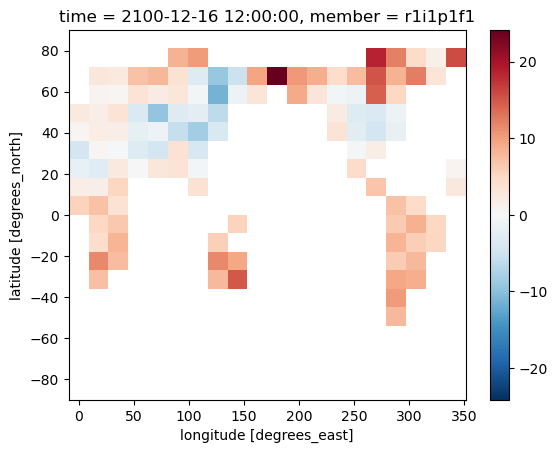

In [66]:
emulations_unstacked.isel(realisation=0, time=3011).plot()

### Saving and/or Analysis

In [67]:
# TODO
# save